In [1]:
#Dependencies
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

#Import API keys
from api_keys import census_key


In [2]:

# Base URL for 2021 ACS data
base_url = "https://api.census.gov/data/2021/acs/acs1"

# Define parameters for the API request
params = {
    "get": "NAME,B01003_001E,B19013_001E,B25077_001E,B25003_001E,B19001_017E,B17001_002E,B25088_001E,B25064_001E,B25063_001E",
    "for": "place:*",  # Get data for all places
    "key": census_key,  # Your API key
}

# Function to fetch data with retry mechanism
def fetch_data_with_retries(url, params, retries=3, delay=5):
    for attempt in range(retries):
        response = requests.get(url, params=params)
        if response.status_code == 200:
            return response
        else:
            print(f"Attempt {attempt + 1}: Failed to fetch data. Retrying in {delay} seconds...")
            time.sleep(delay)
    print("Error: Unable to fetch data after multiple attempts.")
    return None

# Fetch data
response = fetch_data_with_retries(base_url, params)

if response and response.status_code == 200:
    # Convert response to JSON
    data = response.json()
    
    # Convert data to DataFrame
    df = pd.DataFrame(data[1:], columns=data[0])
    
    # Rename columns for clarity
    df.rename(columns={
        "NAME": "City",
        "B01003_001E": "Population",
        "B19013_001E": "Median_Income",
        "B25077_001E": "Median_Home_Value",
        "B25003_001E": "Homeownership_Rate",
        "B19001_017E": "Above_200k",
        "B17001_002E": "Below_Poverty",
        "B25088_001E": "Monthly_Housing_Cost_Mortgage",
        "B25064_001E": "Monthly_Housing_Cost_No_Mortgage",
        "B25063_001E": "Median_Rent"
    }, inplace=True)
    
    # Convert columns to numeric and handle errors
    numeric_columns = [
        "Population", "Median_Income", "Median_Home_Value", "Homeownership_Rate",
        "Above_200k", "Below_Poverty", "Monthly_Housing_Cost_Mortgage",
        "Monthly_Housing_Cost_No_Mortgage", "Median_Rent"
    ]
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Drop rows with missing values in critical columns
    df.dropna(subset=["Population", "Median_Income", "Median_Home_Value", "Above_200k"], inplace=True)
    
    # Calculate derived metrics
    df["Percent_Below_Poverty"] = (df["Below_Poverty"] / df["Population"]) * 100
    df["Housing_Cost_to_Median_Income_Mortgage"] = (df["Monthly_Housing_Cost_Mortgage"] * 12) / df["Median_Income"]
    df["Housing_Cost_to_Median_Income_Rent"] = (df["Median_Rent"] * 12) / df["Median_Income"]
    df["Housing_Cost_to_Median_Income_Rent_Percentage"] = (df["Housing_Cost_to_Median_Income_Rent"] * 100).round(2)
    
    # Filter and sort data
    result_df = df[[
        "City", "Population", "Percent_Below_Poverty", "Median_Income", 
        "Above_200k", "Housing_Cost_to_Median_Income_Mortgage", 
        "Housing_Cost_to_Median_Income_Rent_Percentage", "Median_Home_Value"
    ]]
    result_df = result_df.sort_values(by="Population", ascending=False)

In [3]:
cleaned_df = result_df.dropna()

# Check the shape after cleaning
print("Shape after removing rows with NaN in any column:", cleaned_df.shape)

# If the number of rows is less than 50, add additional cities to reach 50
if cleaned_df.shape[0] < 50:
    additional_cities = pd.DataFrame({
        "City": ["New City"], 
        "Population": [1000000],
        "Housing_Cost_to_Median_Income_Rent_Percentage": [25],
        "Percent_Below_Poverty": [None],
        "Median_Income": [None],
        "Above_200k": [None],
        "Housing_Cost_to_Median_Income_Mortgage": [None],
        "Median_Home_Value": [None]
    })
    cleaned_df = pd.concat([cleaned_df, additional_cities], ignore_index=True)

# Check the final shape again to ensure it's 50 rows
print("Shape after adding new city:", cleaned_df.shape)

# Now, you have removed the rows with NaN in any column and ensured the dataset is complete

Shape after removing rows with NaN in any column: (225, 8)
Shape after adding new city: (225, 8)


In [4]:
# Export to CSV
top_50_cities_df = cleaned_df.head(50)

top_50_cities_df.to_csv('top_50_cities.csv', index=False)

print("Data exported to 'top_50_cities.csv'.")

top_50_cities_df.head()


Data exported to 'top_50_cities.csv'.


,City,Population,Percent_Below_Poverty,Median_Income,Above_200k,Housing_Cost_to_Median_Income_Mortgage,Housing_Cost_to_Median_Income_Rent_Percentage,Median_Home_Value
437,"New York city, New York",8467513,17.705895,67997,417794.0,0.324191,38436.27,685700
95,"Los Angeles city, California",3849306,16.799704,70372,174748.0,0.411812,15161.30,812800
281,"Chicago city, Illinois",2696561,16.742770,66576,131060.0,0.284066,10969.00,297300
535,"Houston city, Texas",2287047,19.026281,55499,83942.0,0.255788,11562.48,236700
19,"Phoenix city, Arizona",1624539,14.738212,68435,51503.0,0.223219,4345.18,352600


In [5]:
# Define function to create Linear Regression plot
def plot_linear_regression(x_values, y_values, cities, title, xlabel, ylabel, ax):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)
    
    # Generate regression line
    regression_line = slope * x_values + intercept
    
    # Assign unique colors to each city
    unique_cities = list(set(cities))
    
    # Use the updated API for getting a colormap (Matplotlib 3.7+)
    cmap = plt.get_cmap("tab20", len(unique_cities))  # Use pyplot's get_cmap function
    
    # Generate a dictionary of colors for each city
    city_colors = {city: cmap(i) for i, city in enumerate(unique_cities)}

    # Plot scatter points color-coded by city
    for city in unique_cities:
        city_mask = (cities == city)
        city_name = city.split(",")[0]  # Remove the state part from the city name
        ax.scatter(
            x_values[city_mask], 
            y_values[city_mask], 
            color=city_colors[city], 
            label=city_name,  # Only show city name without state
            edgecolors="black", 
            alpha=0.75
        )
    
    # Plot regression line without label for the legend
    ax.plot(x_values, regression_line, color="red")
    
    # Add labels, title, and legend
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True)
    
    # Display R-squared value on the plot (at the top-left)
    ax.text(0.05, 0.95, f"R² = {r_value**2:.2f}", transform=ax.transAxes, fontsize=12, verticalalignment='top')
    
    # Display the regression equation below the plot with a red line in front
    ax.text(0.05, 0.05, f"y = {slope:.2f}x + {intercept:.2f}", transform=ax.transAxes, fontsize=12, verticalalignment='bottom')
    
    # Add a red line in front of the equation
    ax.plot([0.05, 0.25], [0.05, 0.05], color='red', transform=ax.transAxes, linewidth=2)

    # Adjust the legend position to the upper right and reduce font size to 6
    ax.legend(loc="upper left", fontsize=6, title="Cities", title_fontsize=8, borderpad=1, bbox_to_anchor=(1.0, 1))
    # Adjust the legend position to the upper right and reduce font size to 6
    ax.legend(loc="upper left", fontsize=6, title="Cities", title_fontsize=8, borderpad=1, bbox_to_anchor=(1.0, 1))

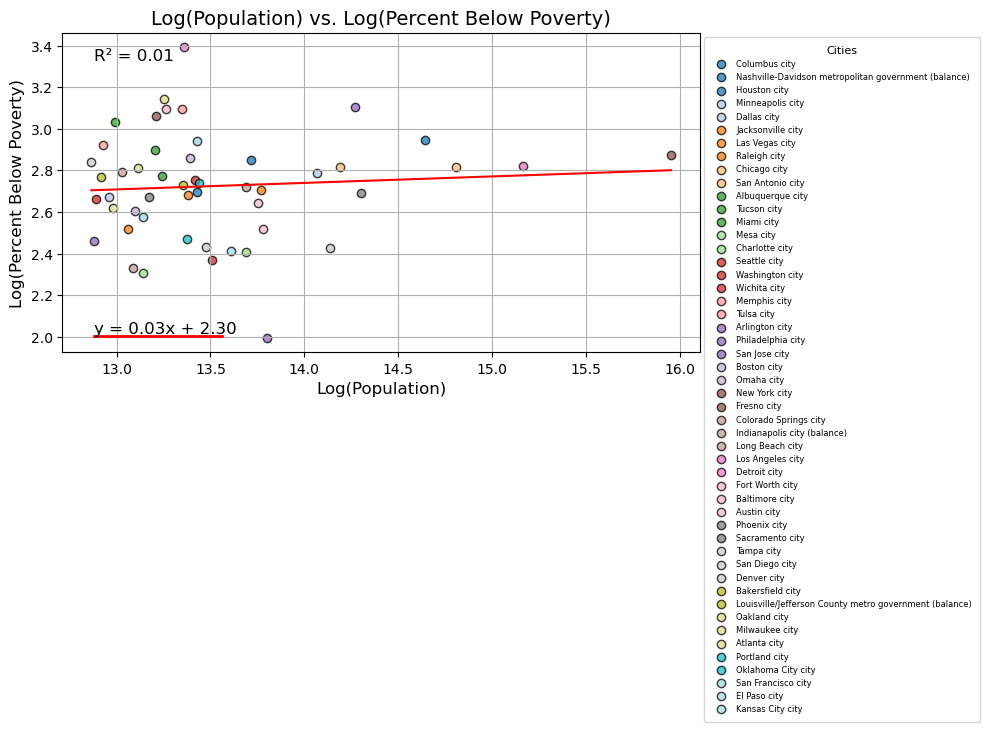

In [6]:
# Example usage (adjust for your specific plot)
x_values = np.log(top_50_cities_df["Population"].values)  # Log transformation of Population
y_values = np.log(top_50_cities_df["Percent_Below_Poverty"].values)  # Log transformation of Percent Below Poverty
cities = top_50_cities_df["City"].values  # City names

# Create the plot with adjusted figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size to make room for the legend

# Call the function to create the linear regression plot with the correct arguments
plot_linear_regression(
    x_values, 
    y_values, 
    cities,  # Make sure to pass the 'cities' argument here
    title="Log(Population) vs. Log(Percent Below Poverty)", 
    xlabel="Log(Population)", 
    ylabel="Log(Percent Below Poverty)", 
    ax=ax
)

# Adjust layout to ensure the legend fits
plt.tight_layout()

# Show plot
plt.show()

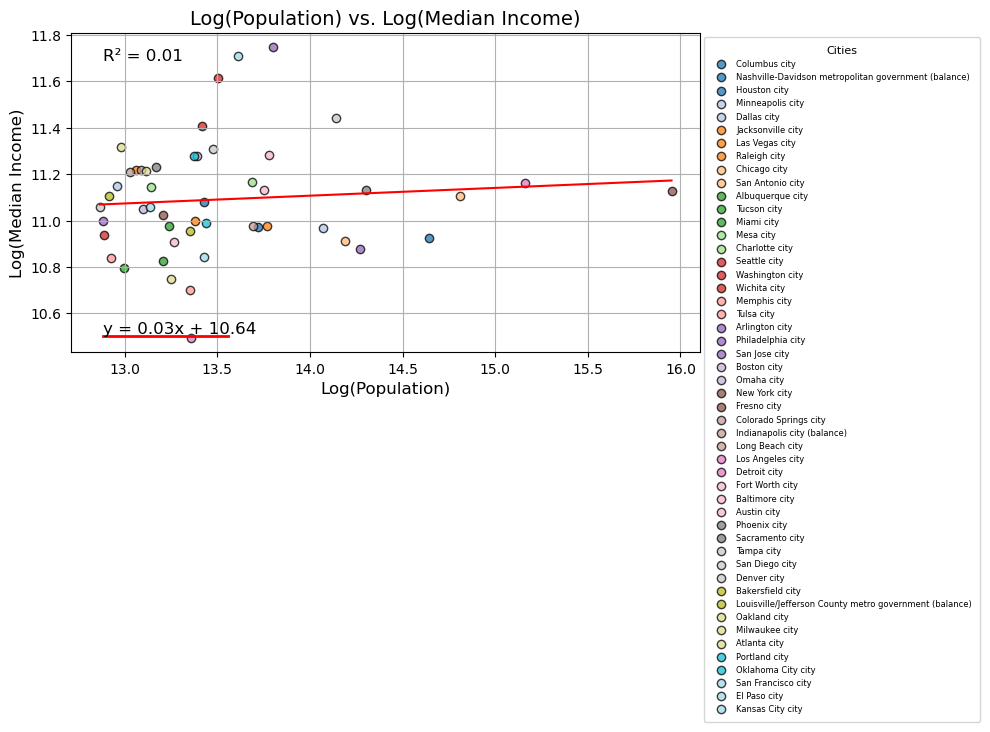

In [7]:
# Example usage (adjust for your specific plot)
x_values = np.log(top_50_cities_df["Population"].values)  # Log transformation of Population
y_values = np.log(top_50_cities_df["Median_Income"].values)  # Log transformation of Median Income
cities = top_50_cities_df["City"].values  # City names

# Create the plot with adjusted figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size to make room for the legend

# Call the function to create the linear regression plot with the correct arguments
plot_linear_regression(
    x_values, 
    y_values, 
    cities,  # Make sure to pass the 'cities' argument here
    title="Log(Population) vs. Log(Median Income)", 
    xlabel="Log(Population)", 
    ylabel="Log(Median Income)", 
    ax=ax
)

# Adjust layout to ensure the legend fits
plt.tight_layout()

# Show plot
plt.show()

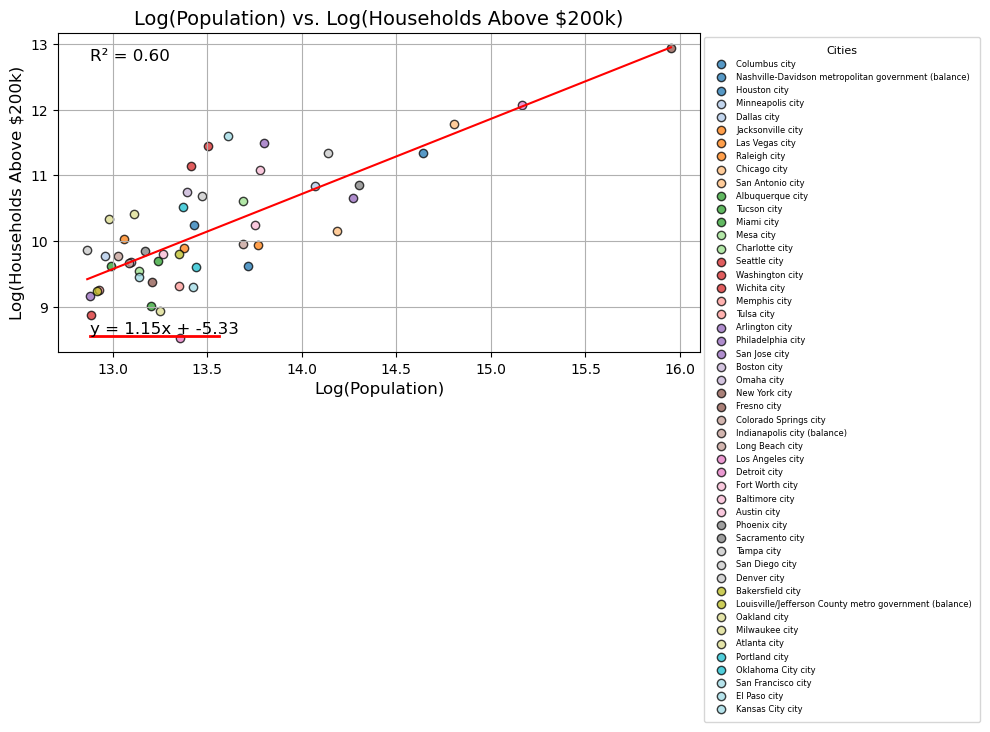

In [8]:
# Example usage (adjust for your specific plot)
x_values = np.log(top_50_cities_df["Population"].values)  # Log transformation of Population
y_values = np.log(top_50_cities_df["Above_200k"].values)  # Log transformation of households above $200k
cities = top_50_cities_df["City"].values  # City names

# Create the plot with adjusted figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size to make room for the legend

# Call the function to create the linear regression plot with the correct arguments
plot_linear_regression(
    x_values, 
    y_values, 
    cities,  # Make sure to pass the 'cities' argument here
    title="Log(Population) vs. Log(Households Above $200k)", 
    xlabel="Log(Population)", 
    ylabel="Log(Households Above $200k)", 
    ax=ax
)

# Adjust layout to ensure the legend fits
plt.tight_layout()

# Show plot
plt.show()

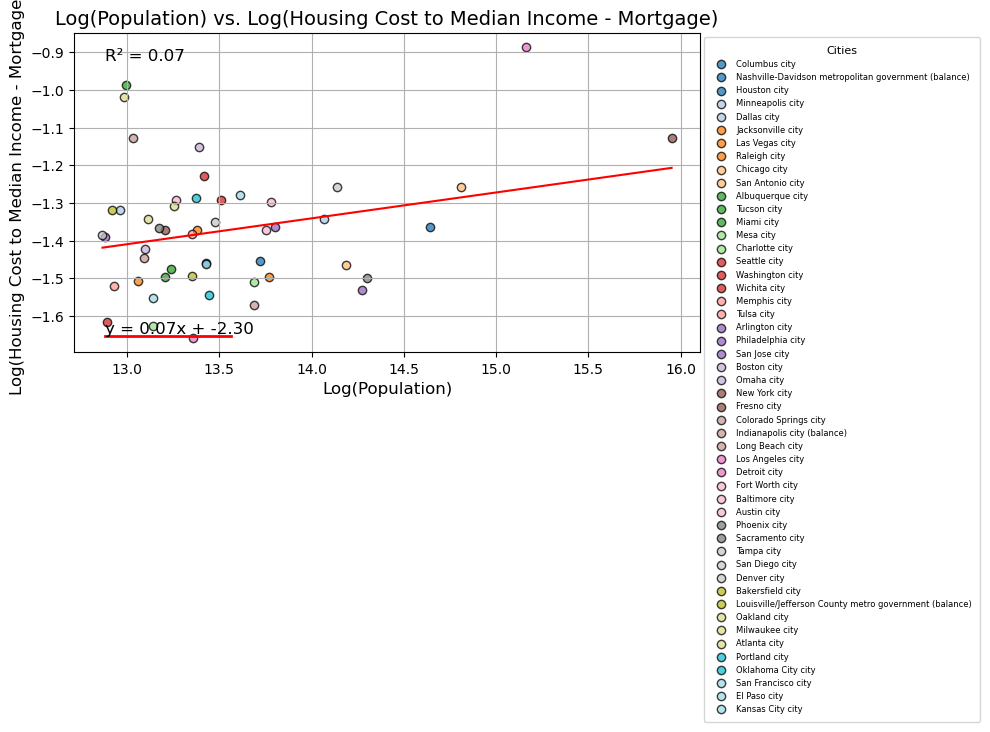

In [9]:
# Example usage (adjust for your specific plot)
x_values = np.log(top_50_cities_df["Population"].values)  # Log transformation of Population
y_values = np.log(top_50_cities_df["Housing_Cost_to_Median_Income_Mortgage"].values)  # Log transformation of Housing Cost to Median Income (Mortgage)
cities = top_50_cities_df["City"].values  # City names

# Create the plot with adjusted figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size to make room for the legend

# Call the function to create the linear regression plot with the correct arguments
plot_linear_regression(
    x_values, 
    y_values, 
    cities,  # Make sure to pass the 'cities' argument here
    title="Log(Population) vs. Log(Housing Cost to Median Income - Mortgage)", 
    xlabel="Log(Population)", 
    ylabel="Log(Housing Cost to Median Income - Mortgage)", 
    ax=ax
)

# Adjust layout to ensure the legend fits
plt.tight_layout()

# Show plot
plt.show()

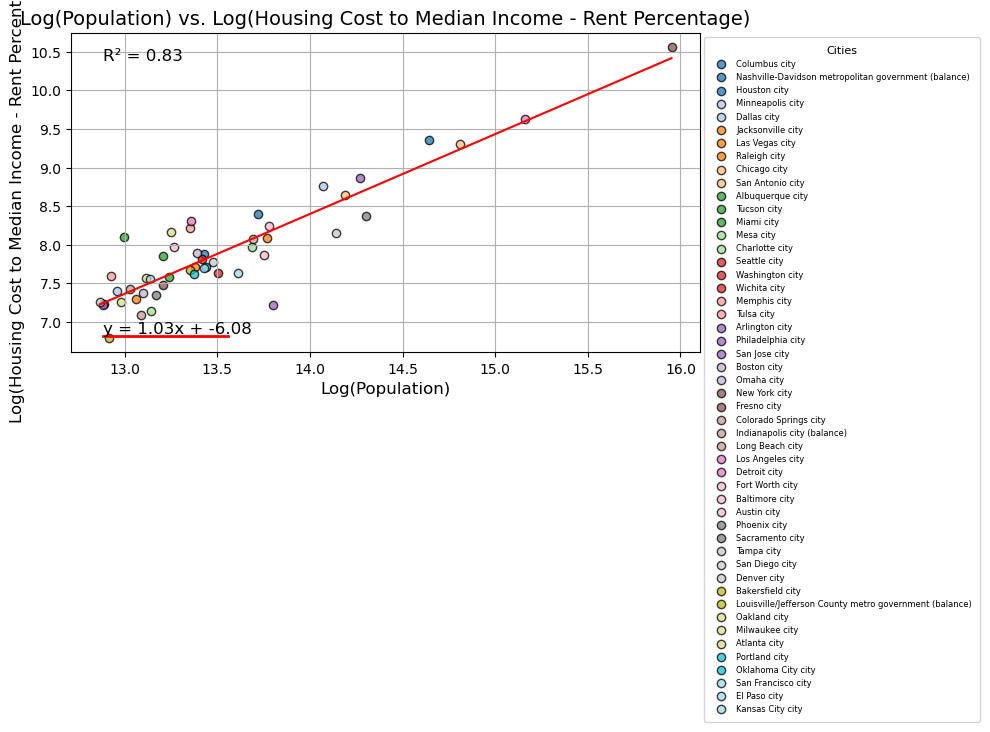

In [10]:
# Example usage (adjust for your specific plot)
# Ensure no zero or negative values before applying log transformation
# Replace zeros with a small positive number for both Population and Housing Cost columns using .loc[]
top_50_cities_df.loc[:, "Housing_Cost_to_Median_Income_Rent_Percentage"] = top_50_cities_df["Housing_Cost_to_Median_Income_Rent_Percentage"].replace(0, 1e-5)
top_50_cities_df.loc[:, "Population"] = top_50_cities_df["Population"].replace(0, 1e-5)

x_values = np.log(top_50_cities_df["Population"].values)  # Log transformation of Population
y_values = np.log(top_50_cities_df["Housing_Cost_to_Median_Income_Rent_Percentage"].values)  # Log transformation of Housing Cost to Median Income Rent Percentage
cities = top_50_cities_df["City"].values  # City names

# Create the plot with adjusted figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size to make room for the legend

# Call the function to create the linear regression plot with the correct arguments
plot_linear_regression(
    x_values, 
    y_values, 
    cities,  # Make sure to pass the 'cities' argument here
    title="Log(Population) vs. Log(Housing Cost to Median Income - Rent Percentage)", 
    xlabel="Log(Population)", 
    ylabel="Log(Housing Cost to Median Income - Rent Percentage)", 
    ax=ax
)

# Adjust layout to ensure the legend fits
plt.tight_layout()

# Show plot
plt.show()